In [2]:
import pandas as pd

# Load previously saved metrics
metrics_df = pd.read_csv("../outputs/metrics_df_final.csv")


In [3]:
from sklearn.preprocessing import StandardScaler

# Select relevant features for segmentation
segmentation_features = metrics_df[['CLTV', 'Churn_Probability', 'Risk_Score_Normalized', 'customer_tenure', 'ARPU']].copy()

# Fill missing values with 0 
segmentation_features = segmentation_features.fillna(0)

# Scale the features
scaler = StandardScaler()
segmentation_scaled = scaler.fit_transform(segmentation_features)


In [4]:
from sklearn.utils import resample

sampled_features = resample(segmentation_scaled, n_samples=10000, random_state=42)


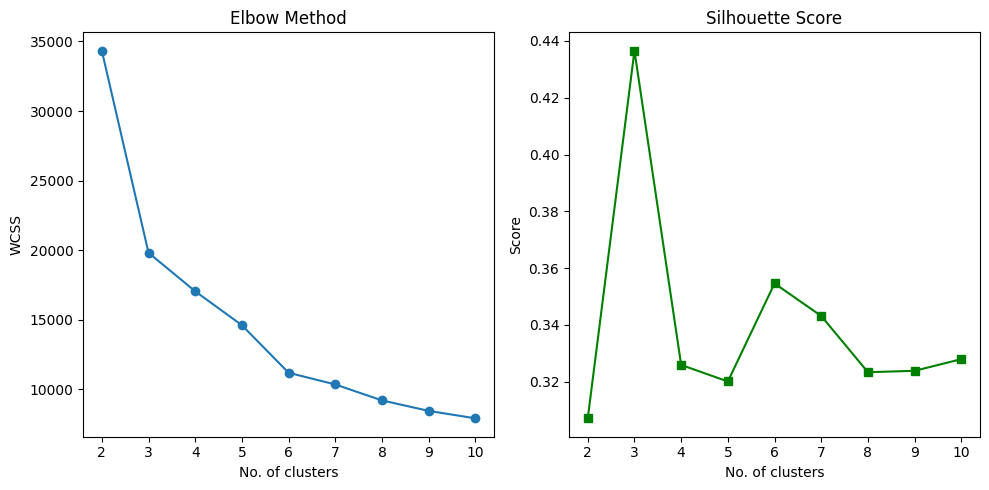

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(sampled_features)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(sampled_features, kmeans.labels_))

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('No. of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='s', color='green')
plt.title('Silhouette Score')
plt.xlabel('No. of clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


Customer Segment Profiles:

             CLTV  Churn_Probability  Risk_Score_Normalized  customer_tenure  \
Segment                                                                        
0        13099.77               0.13                   0.24           115.66   
1         3749.01               0.21                   0.24           144.09   
2         3294.66               0.88                   0.51           118.37   
3         3856.43               0.20                   0.24           110.67   

           ARPU   Count  
Segment                  
0        270.25  255257  
1         93.25  309630  
2         69.25  265910  
3        100.07  514553  


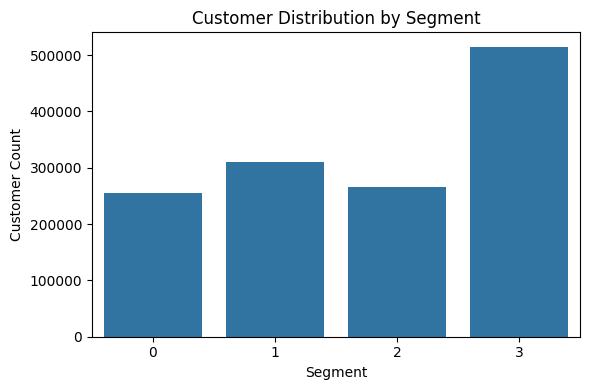

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select features for clustering
segmentation_features = metrics_df[['CLTV', 'Churn_Probability', 'Risk_Score_Normalized', 'customer_tenure', 'ARPU']].copy()
segmentation_features = segmentation_features.fillna(0)

# Scale the features
scaler = StandardScaler()
segmentation_scaled = scaler.fit_transform(segmentation_features)

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(segmentation_scaled)

# Add cluster labels to metrics_df
metrics_df['Segment'] = cluster_labels

# Define business-friendly segment names
segment_labels = {
    0: "Budget Loyalists",           # Low ARPU, loyal, low churn
    1: "High-Value Champions",       # High ARPU, lowest churn, stable
    2: "Long-term Sleepers",         # Long tenure, avg value, mid churn
    3: "At-Risk Value Drainers"      # Low ARPU, high churn, risky
}

# Map Segment to labels
metrics_df["Segment_Label"] = metrics_df["Segment"].map(segment_labels)

# Save the updated DataFrame
metrics_df.to_csv("../outputs/metrics_df_segmented.csv", index=False)

# Segment Summary
segment_summary = metrics_df.groupby('Segment').agg({
    'CLTV': 'mean',
    'Churn_Probability': 'mean',
    'Risk_Score_Normalized': 'mean',
    'customer_tenure': 'mean',
    'ARPU': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'Count'}).round(2)

# Display the summary
print("Customer Segment Profiles:\n")
print(segment_summary)

# Visualize segment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Segment', data=metrics_df)
plt.title("Customer Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.savefig("../outputs/customer_distribution_by_segment.png", dpi=300, bbox_inches='tight')
plt.show()


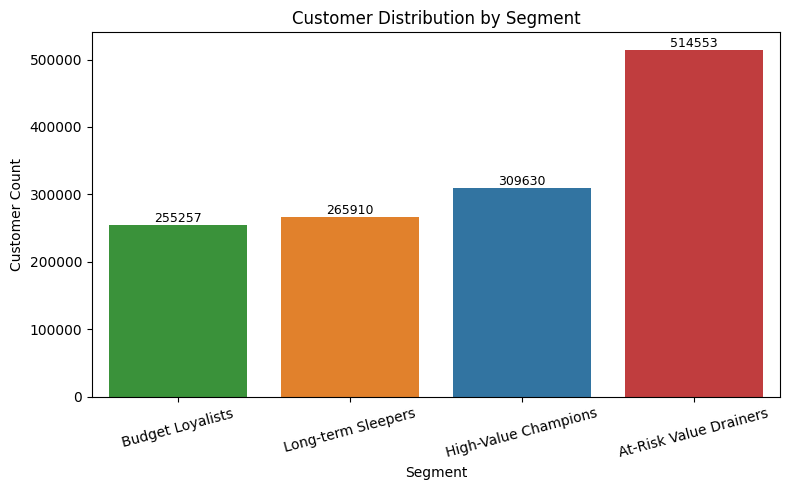

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select features for clustering
segmentation_features = metrics_df[['CLTV', 'Churn_Probability', 'Risk_Score_Normalized', 'customer_tenure', 'ARPU']].copy()
segmentation_features = segmentation_features.fillna(0)

# Scale the features
scaler = StandardScaler()
segmentation_scaled = scaler.fit_transform(segmentation_features)

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(segmentation_scaled)

# Add cluster labels to the dataframe
metrics_df['Segment'] = cluster_labels

# Segment mapping
segment_labels = {
    0: "Budget Loyalists",           
    1: "High-Value Champions",       
    2: "Long-term Sleepers",         
    3: "At-Risk Value Drainers"      
}
metrics_df["Segment_Label"] = metrics_df["Segment"].map(segment_labels)

palette = {
    "Budget Loyalists": "#2ca02c",      # Green
    "High-Value Champions": "#1f77b4",  # Blue
    "Long-term Sleepers": "#ff7f0e",    # Orange
    "At-Risk Value Drainers": "#d62728" # Red
}

# Enhanced bar chart
plt.figure(figsize=(8, 5))
order = metrics_df['Segment_Label'].value_counts().sort_values().index
ax = sns.countplot(x='Segment_Label', data=metrics_df, hue='Segment_Label', palette=palette, order=order, legend=False)
plt.title("Customer Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Customer Count")
plt.xticks(rotation=15)

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=9)

plt.tight_layout()

#  Save to file
plt.savefig('../outputs/customer_segment_distribution.png', dpi=300)
plt.show()

In [8]:
# Save the updated DataFrame with assigned segments
metrics_df.to_csv("../outputs/metrics_df_segmented_labeled.csv", index=False)



In [9]:
segment_summary.reset_index(inplace=True)
for _, row in segment_summary.iterrows():
    print(f"Segment {int(row['Segment'])}:")
    print(f"  CLTV: ${row['CLTV']:.2f}")
    print(f"  Churn Probability: {row['Churn_Probability']:.2f}")
    print(f"  Risk Score: {row['Risk_Score_Normalized']:.2f}")
    print(f"  Tenure: {row['customer_tenure']:.1f} months")
    print(f"  ARPU: ${row['ARPU']:.2f}")
    print(f"  Customer Count: {int(row['Count'])}")
    print("-" * 40)


Segment 0:
  CLTV: $13099.77
  Churn Probability: 0.13
  Risk Score: 0.24
  Tenure: 115.7 months
  ARPU: $270.25
  Customer Count: 255257
----------------------------------------
Segment 1:
  CLTV: $3749.01
  Churn Probability: 0.21
  Risk Score: 0.24
  Tenure: 144.1 months
  ARPU: $93.25
  Customer Count: 309630
----------------------------------------
Segment 2:
  CLTV: $3294.66
  Churn Probability: 0.88
  Risk Score: 0.51
  Tenure: 118.4 months
  ARPU: $69.25
  Customer Count: 265910
----------------------------------------
Segment 3:
  CLTV: $3856.43
  Churn Probability: 0.20
  Risk Score: 0.24
  Tenure: 110.7 months
  ARPU: $100.07
  Customer Count: 514553
----------------------------------------


In [10]:
# Define segment strategies
retention_strategy = {
    "Budget Loyalists": "Introduce loyalty-based upselling (e.g., bundles, premium offers)",
    "High-Value Champions": "Offer personalized rewards, VIP programs, early access deals",
    "At-Risk Value Drainers": "Reduce CAC, send win-back offers, or move to low-cost channels",
    "Long-term Sleepers": "Re-engage with targeted campaigns or consider deactivation"
}

# Map to main DataFrame
metrics_df['Retention_Strategy'] = metrics_df['Segment_Label'].map(retention_strategy)

# Display few samples
metrics_df[['customer_id', 'Segment_Label', 'Retention_Strategy']].head()


,customer_id,Segment_Label,Retention_Strategy
0,959339,High-Value Champions,"Offer personalized rewards, VIP programs, earl..."
1,959322,High-Value Champions,"Offer personalized rewards, VIP programs, earl..."
2,959330,High-Value Champions,"Offer personalized rewards, VIP programs, earl..."
3,959329,High-Value Champions,"Offer personalized rewards, VIP programs, earl..."
4,959317,High-Value Champions,"Offer personalized rewards, VIP programs, earl..."


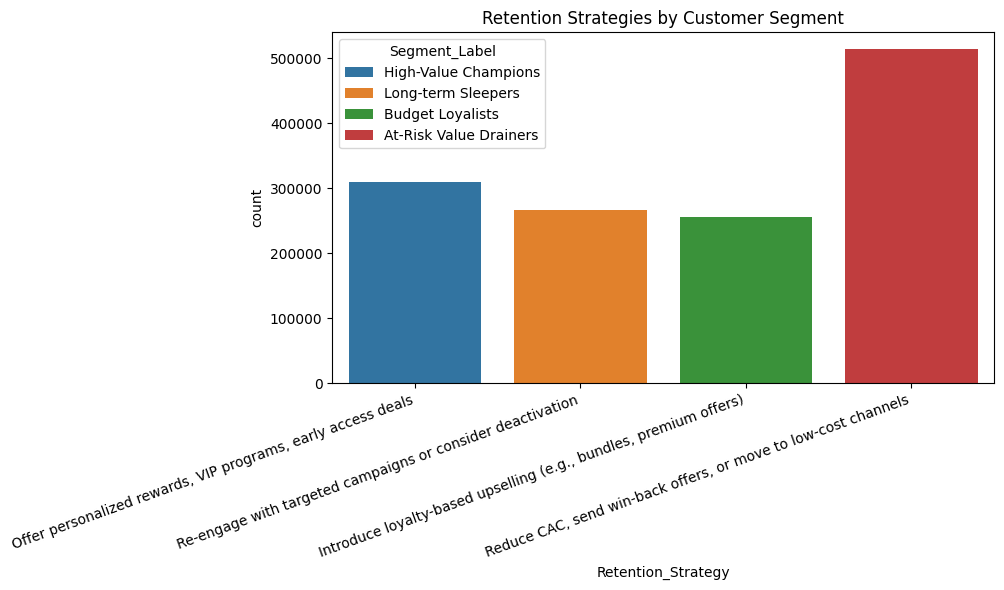

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=metrics_df, x='Retention_Strategy', hue='Segment_Label', palette=palette)
plt.xticks(rotation=20, ha='right')
plt.title("Retention Strategies by Customer Segment")
plt.tight_layout()
plt.savefig("../outputs/retention_strategy_by_segment.png", dpi=300, bbox_inches='tight')
plt.show()


In [12]:
# Segment labels mapping
segment_labels = {
    0: "Budget Loyalists",
    1: "High-Value Champions",
    2: "Long-term Sleepers",
    3: "At-Risk Value Drainers"
}

# Apply mapping
metrics_df["Segment_Label"] = metrics_df["Segment"].map(segment_labels)


In [13]:
loan_kpi_df = metrics_df.copy()
loan_kpi_df.to_csv("../outputs/loan_kpi_with_segment.csv", index=False)


In [14]:
print(loan_kpi_df['Segment_Label'].value_counts())


Segment_Label
At-Risk Value Drainers    514553
High-Value Champions      309630
Long-term Sleepers        265910
Budget Loyalists          255257
Name: count, dtype: int64


In [15]:
loan_kpi_df.to_csv("../data/processed/finsurf_segment_kpis.csv", index=False)
